# Time series analysis of crime data with ARIMA models

In [1]:
from __future__ import print_function
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.api as smtsa
import statsmodels.api as sm
import os
import numpy as np
import datetime
from dateutil.relativedelta import relativedelta
from pyramid.arima import auto_arima
%matplotlib inline

## Load in PSNI crime data for the last 3 years

In [2]:
datas = []
os.chdir('/home/jborland/crime/data')
for month in os.listdir("data"):
    for file in os.listdir("data/" + month):
        if '-street.csv' in file:
            datas.append(pd.read_csv("data/" + month + "/" + file, usecols=['Month','Reported by','Falls within','Crime type']))

#os.chdir('/data/mdoherty/crime')
#for month in os.listdir("data"):
#    for file in os.listdir("data/" + month):
#        if '-street.csv' in file:
#            datas.append(pd.read_csv("data/" + month + "/" + file, usecols=['Month','Reported by','Falls within','Crime type']))
            
data = pd.concat(datas)
data['Month'] = pd.to_datetime(data['Month'])

In [3]:
data_bymonth = data.groupby(['Month']).size().reset_index(name='counts')
data_bymonth.columns = ['Month','Number of crimes']
data_bymonth['Month'] = pd.to_datetime(data_bymonth['Month'], '%Y-%m-%d')
data_bymonth.index = data_bymonth['Month']
data_bymonth.drop('Month', axis=1, inplace=True)
data_bymonth.tail()

,Number of crimes
Month,
2018-04-01,545513
2018-05-01,584474
2018-06-01,578325
2018-07-01,604157
2018-08-01,564840


In [4]:
def plotds(xt, nlag=35, fig_size=(12, 10)):
    if not isinstance(xt, pd.Series):
         xt = pd.Series(xt)
    plt.figure(figsize=fig_size)
    layout = (2, 2)
    
    # Assign axes
    ax_xt = plt.subplot2grid(layout, (0, 0), colspan=2)
    ax_acf = plt.subplot2grid(layout, (1, 0))
    ax_pacf = plt.subplot2grid(layout, (1, 1))
    
    # Plot graphs
    xt.plot(ax=ax_xt)
    ax_xt.set_title('Time Series of the Number of Crimes in Recent Years')
    plot_acf(xt, lags=35, ax=ax_acf)
    plot_pacf(xt, lags=35, ax=ax_pacf)
    plt.tight_layout()
    return None

/usr/local/lib/python3.5/dist-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


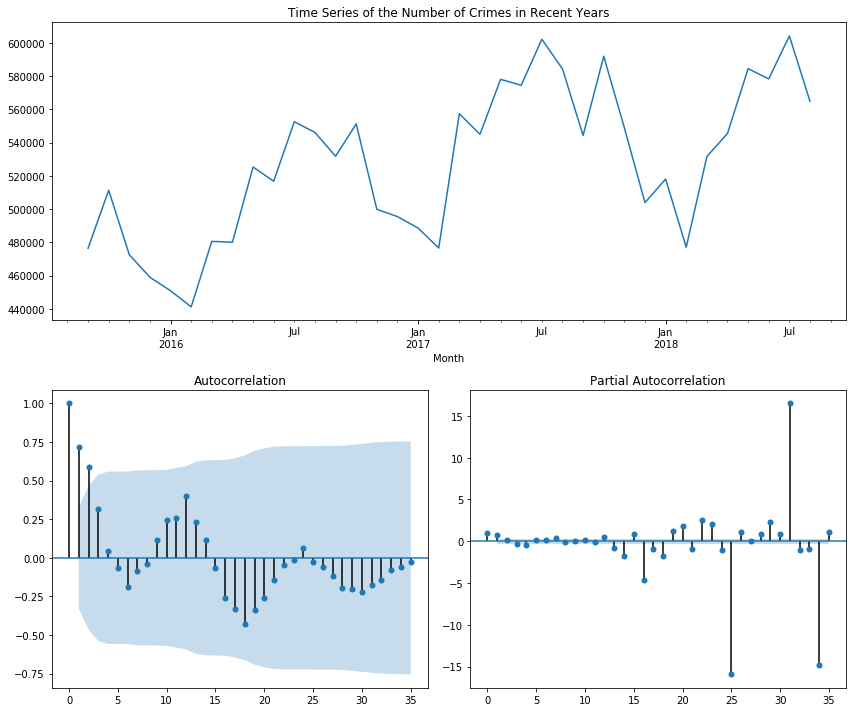

In [5]:
plotds(data_bymonth['Number of crimes'])

Plotting the time series and auto-correlation functions (ACFs) shows some evidence of *non-stationarity*, i.e. the mean and variance of the data resemble a function of time. This is confirmed by comparing the mean and variance for two different halves of the series:

In [6]:
mean1, mean2 = data_bymonth.iloc[:18]['Number of crimes'].mean(), data_bymonth.iloc[18:]['Number of crimes'].mean()
var1, var2 = data_bymonth.iloc[:18]['Number of crimes'].var(), data_bymonth.iloc[18:]['Number of crimes'].var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=497606.000000, mean2=557485.111111
variance1=1164316237.058824, variance2=1182838640.575163


We can see that the mean and variance are not constant over time, i.e. the underlying data points are not stationary.

### Stationarize the data

One technique to try when confronted with a non-stationary series is **differencing**. We fit a model not to the original time series $X_t$, but rather to the **lag n differenced series**

$$\nabla X_t = X_t - X_{t-n}. $$

We plot the original time series together with several lag n difference below. 

Text(0.5,1,'Third-order differences of crimes during Sept 2015 - Aug 2018')

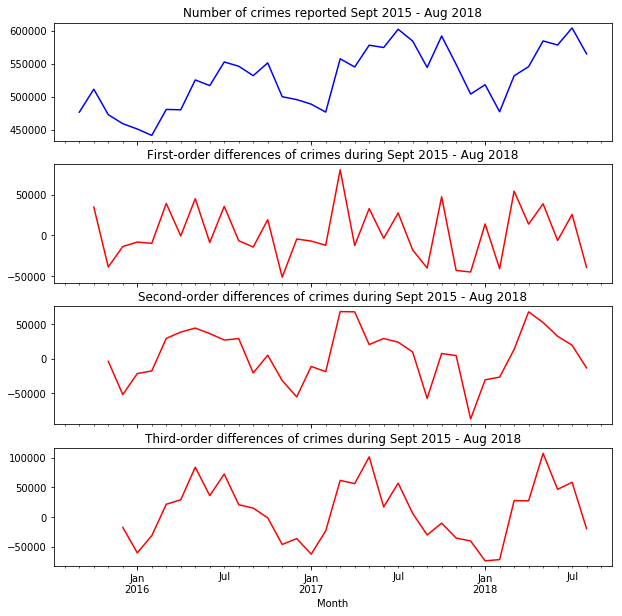

In [7]:
first_order_diff=data_bymonth['Number of crimes'].diff(1).dropna()
second_order_diff=data_bymonth['Number of crimes'].diff(2).dropna()
third_order_diff=data_bymonth['Number of crimes'].diff(3).dropna()

fig,ax=plt.subplots(4, sharex=True)
fig.set_size_inches(10, 10)
data_bymonth['Number of crimes'].plot(ax=ax[0], color='b')
ax[0].set_title('Number of crimes reported Sept 2015 - Aug 2018')
first_order_diff.plot(ax=ax[1], color='r')
ax[1].set_title('First-order differences of crimes during Sept 2015 - Aug 2018')
second_order_diff.plot(ax=ax[2], color='r')
ax[2].set_title('Second-order differences of crimes during Sept 2015 - Aug 2018')
third_order_diff.plot(ax=ax[3], color='r')
ax[3].set_title('Third-order differences of crimes during Sept 2015 - Aug 2018')

Either a first-order or second-order difference appears to be more stationary. Given a collection of models for the data, AIC estimates the quality of each model, relative to each of the other models. Generally, a lower AIC refers to a model with a better fit.

By comparing different values of d, p and q we find the optimal model to be (p=1, d=2, q=1). 

In [8]:
aicVal=[]
for d in range(1,3):
    for ari in range(0, 3):
        for maj in range(0,3):
            try:
                arima_obj = ARIMA(data_bymonth['Number of crimes'].astype(float).tolist(), order=(ari,d,maj))
                arima_obj_fit = arima_obj.fit(disp=0)
                aicVal.append([ari, d, maj, arima_obj_fit.aic])
            except ValueError:
                pass           
aicVal

/usr/local/lib/python3.5/dist-packages/scipy/signal/signaltools.py:1333: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/usr/local/lib/python3.5/dist-packages/scipy/signal/signaltools.py:1336: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/usr/local/lib/python3.5/dist-packages/scipy/signal/signaltools.py:1342: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `ar

[[0, 1, 0, 830.2886235863514],
 [0, 1, 1, 829.8603668808149],
 [0, 1, 2, 826.7351529224168],
 [1, 1, 0, 828.7893011819336],
 [1, 1, 1, 830.2465648999112],
 [1, 1, 2, 828.7306386106334],
 [2, 1, 0, 829.5392447760831],
 [2, 1, 1, 831.4583578929964],
 [2, 1, 2, 829.0264929108579],
 [0, 2, 0, 839.103144220887],
 [0, 2, 1, 813.2053247540288],
 [1, 2, 0, 817.7767896957444],
 [1, 2, 1, 812.3426401507667],
 [1, 2, 2, 813.7167410096793],
 [2, 2, 0, 814.5668903920903],
 [2, 2, 1, 815.4961811988334]]

In [9]:
# Optimal ARIMA model is 1,2,1 - can see this as it's the min aicVal
arima_mod = ARIMA(data_bymonth['Number of crimes'].astype(float).tolist(), order=(1,2,1))
arima_mod_fit = arima_mod.fit(disp=0)
arima_mod_fit.summary()

/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                   D2.y   No. Observations:                   34
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -402.171
Method:                       css-mle   S.D. of innovations          31212.918
Date:                Tue, 30 Oct 2018   AIC                            812.343
Time:                        14:54:59   BIC                            818.448
Sample:                             2   HQIC                           814.425
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.2126    413.118      0.037      0.971    -794.484     824.910
ar.L1.D2.y    -0.2953      0.169     -1.750      0.090      -0.626       0.035
ma.L1.D2.y    -1.0000      0.086    -11.672      0.000      -1.168      -0.832
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -3.3868           +0.0000j            3.3868            0.5000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

We can evaluate quality of predictions from the model and plot the differenced-data against its predictions

Text(0,0.5,'Number of Crimes')

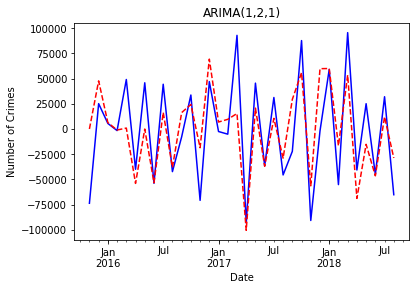

In [10]:
pred = np.append([0,0],arima_mod_fit.fittedvalues.tolist())
data_bymonth['ARIMA'] = pred

diffval = np.append([0,0], arima_mod_fit.resid+arima_mod_fit.fittedvalues)
data_bymonth['diffval'] = diffval

f, axarr = plt.subplots(1, sharex=True)
data_bymonth['diffval'].iloc[2:].plot(color='b', linestyle = '-', ax=axarr)
data_bymonth['ARIMA'].iloc[2:].plot(color='r', linestyle = '--', ax=axarr)
axarr.set_title('ARIMA(1,2,1)')
plt.xlabel('Date')
plt.ylabel('Number of Crimes')

We can also critique the residuals left over, and assess their linearity.

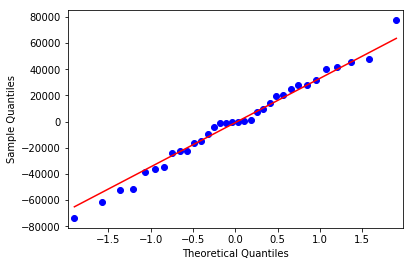

In [11]:
dj_resid_qq = sm.qqplot(arima_mod_fit.resid, line='s')

This model seems like a fair fit, covering some of the spikes and in the correct space. However, the residuals still look to be holding a pattern, and therefore we should aim to refine our model further.

### Investigating seasonality

Text(0.5,0.98,'Decomposition of Crime data')

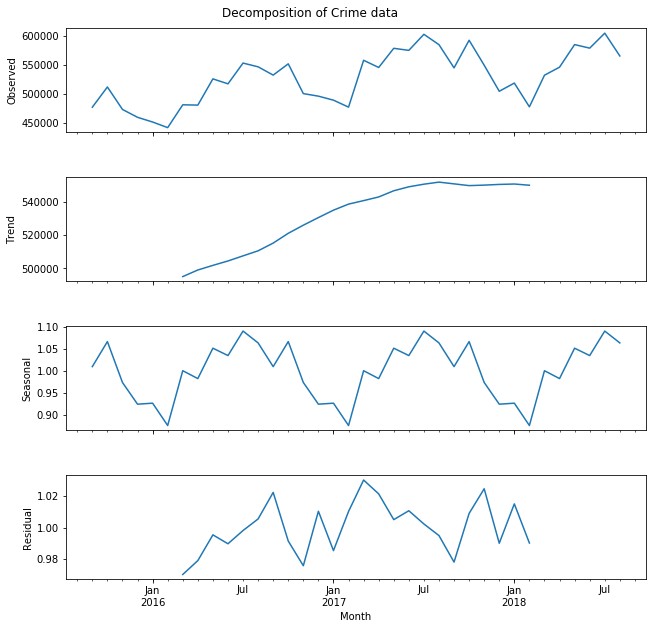

In [12]:
result = seasonal_decompose(data_bymonth.drop(['ARIMA','diffval'],axis=1), model='multiplicative')    
fig = result.plot()
fig.set_size_inches(10,10)
fig.suptitle('Decomposition of Crime data')

From this, it is clear that crime data has a seasonal component. It make sense to use a Seasonal ARIMA model. In order to do this we will need to choose p,d,q values for the ARIMA, and P,D,Q values for the Seasonal component.

In [13]:
stepwise_model = auto_arima(data_bymonth.drop(['ARIMA','diffval'],axis=1), start_p=0, start_q=0,
                           max_p=5, max_q=5, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True,
                           n_fits=25)
print(stepwise_model.aic())

Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=523.844, BIC=526.115, Fit time=0.030 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=526.576, BIC=531.118, Fit time=0.262 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=524.845, BIC=528.252, Fit time=0.142 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=525.722, BIC=529.129, Fit time=0.055 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=525.779, BIC=529.186, Fit time=0.054 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=527.757, BIC=532.299, Fit time=0.256 seconds
Total fit time: 0.808 seconds
523.8436408082841


In general, models with a lower AIC are a better fit - the minimum here uses order=(0, 1, 0) and seasonal_order=(0, 1, 0, 12)

In [14]:
train = data_bymonth.drop(['ARIMA','diffval'],axis=1).loc['2015-09-01':'2017-08-01']
test = data_bymonth.drop(['ARIMA','diffval'],axis=1).loc['2017-09-01':]

stepwise_model.fit(train)
test_forecast = stepwise_model.predict(n_periods=12)

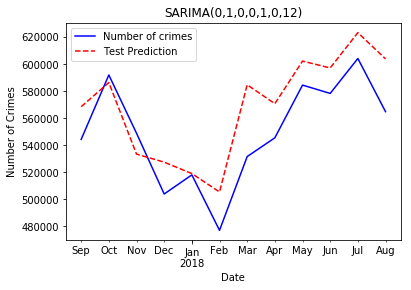

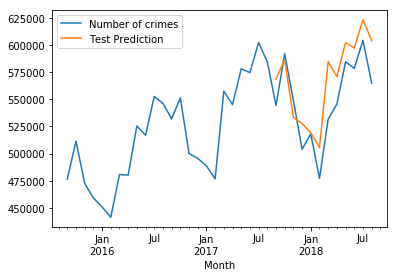

In [15]:
test_forecast = pd.DataFrame(test_forecast,index = test.index,columns=['Test Prediction'])
f2, axarr2 = plt.subplots(1, sharex=True)
test.plot(color='b', linestyle = '-', ax=axarr2)
test_forecast.plot(color='r', linestyle = '--', ax=axarr2)
axarr2.set_title('SARIMA(0,1,0,0,1,0,12)')
plt.xlabel('Date')
plt.ylabel('Number of Crimes')

pd.concat([data_bymonth.drop(['ARIMA','diffval'],axis=1),test_forecast],axis=1).plot()

We can now refit our model to our entire data set and then forecast into the future.

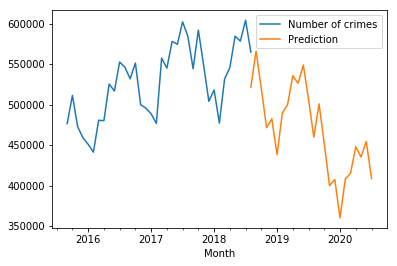

In [16]:
stepwise_model.fit(data_bymonth.drop(['ARIMA','diffval'],axis=1))
future_forecast = stepwise_model.predict(n_periods=24)

future_forecast = pd.DataFrame({'Prediction': future_forecast,'Month': pd.date_range(start='2018-08-01', periods=24, freq='MS')})
future_forecast.index = future_forecast['Month']
future_forecast.drop('Month', axis=1, inplace=True)

pd.concat([data_bymonth.drop(['ARIMA','diffval'],axis=1),future_forecast],axis=1).plot()

## Investigate trends of different crime types

In [17]:
# TODO

#types = data['Crime type'].unique()
#trendByType = pd.DataFrame()
#seasonaltrendByType = pd.DataFrame()

#data_bymonthandtype = data.groupby(['Month','Crime type']).size().reset_index(name='counts')
#data_bymonthandtype.columns = ['Month','Crime type','Number of crimes']
#data_bymonthandtype['Month'] = pd.to_datetime(data_bymonthandtype['Month'], '%Y-%m-%d')

#for typ in types:
 #   datafortype = data_bymonthandtype[data_bymonthandtype['Crime type'] == typ][['Month','Number of crimes']]
 #   datafortype.columns = ['ds','y']
 #   print(datafortype.head())